<a href="https://colab.research.google.com/github/gustavo-duarte-silva/ML-Venda-Veiculos/blob/main/Venda_Veiculo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#Dataset obtido no Kaggle
df = pd.read_csv('/content/drive/MyDrive/CIENTISTA DE DADOS/PROJETOS/VENDA DE VEICULO/Used_Car_Price_Data.csv')
df

,Name,Price($),Milage,Review,Review_count,Badge
0,2021 Toyota Camry SE,"31,150","13,390",4.5,659,Good Deal
1,2021 Toyota Supra 3.0 Premium,"58,981","7,348",4.8,"2,744",Great Deal
2,2019 Toyota Sequoia Platinum,"51,999","55,121",4.5,"2,092",Great Deal
3,2019 Toyota Camry SE,"25,689","49,126",1.0,1,Good Deal
4,2017 Toyota Highlander Limited,"31,591","84,621",4.9,"1,745",Good Deal
...,...,...,...,...,...,...
995,2019 Toyota RAV4 Hybrid XLE,"36,981","11,872",4.4,640,Good Deal
996,2010 Toyota Prius IV,"7,995","1,90,884",4.7,"1,432",Good Deal
997,2000 Toyota 4Runner SR5,"15,995","1,45,199",4.1,11,Home Delivery
998,2019 Toyota Corolla LE,"19,989","23,814",4.9,337,Good Deal


In [5]:
#Convertendo os Dados
df['Price($)'] = df['Price($)'].str.replace(',','').astype(float)
df['Milage'] = df['Milage'].str.replace(',','').astype(float)
df.rename(columns={'Price($)':'Price'}, inplace=True)
df = df.drop(columns=['Review_count', 'Badge','Name'])

In [6]:
df.head()

,Price,Milage,Review
0,31150.0,13390.0,4.5
1,58981.0,7348.0,4.8
2,51999.0,55121.0,4.5
3,25689.0,49126.0,1.0
4,31591.0,84621.0,4.9


In [7]:
df.dtypes

Price     float64
Milage    float64
Review    float64
dtype: object

In [8]:
df.isnull().any()

Price     False
Milage    False
Review     True
dtype: bool

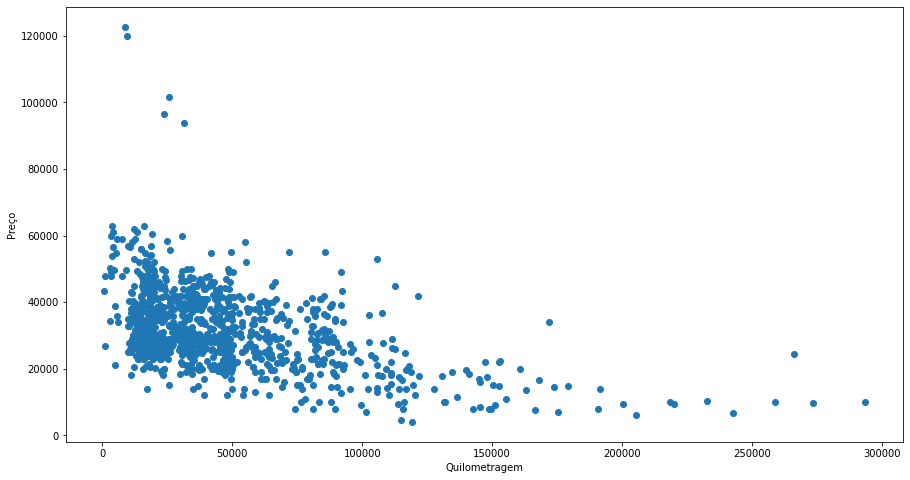

In [13]:
plt.figure(figsize=[15,8])
plt.xlabel('Quilometragem')
plt.ylabel("Preço")
plt.scatter(df['Milage'], df['Price'])
plt.show()

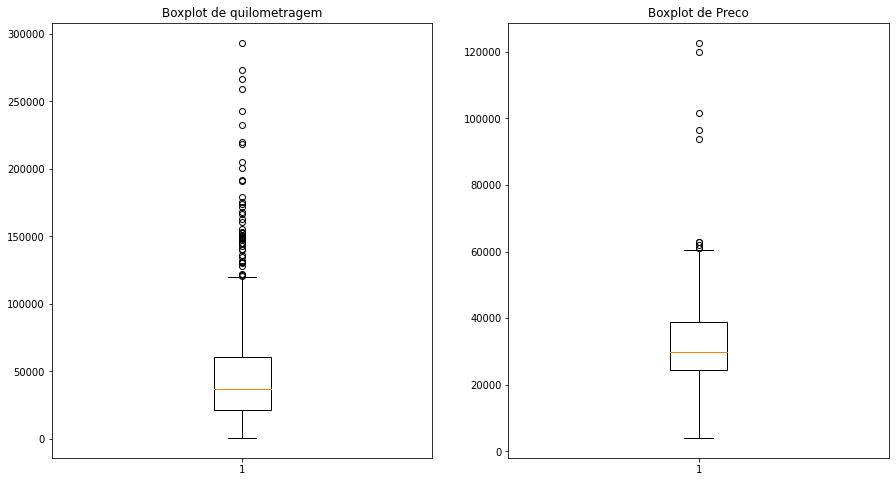

In [14]:
#Verificando Outliers

plt.figure(figsize=[15,8])
plt.subplot(1,2,1)
plt.title("Boxplot de quilometragem")
plt.boxplot(df.Milage)
plt.subplot(1,2,2)
plt.title('Boxplot de Preco')
plt.boxplot(df.Price)
plt.show()

In [15]:
#Função que Remove Outlier
def detecta_outlier(x, limite = 1.5):
    iqr = np.percentile(x, 75) - np.percentile(x, 25)
    limite_inf = np.maximum(np.percentile(x, 25) - limite * iqr, np.min(x))
    limite_sup = np.minimum(np.percentile(x, 75) + limite * iqr, np.max(x))
    return np.where((x < limite_inf) | (x > limite_sup), 1, 0)

In [16]:
df['outlier_milage'] = detecta_outlier(df.Milage)
df['outlier_price'] = detecta_outlier(df.Price)

In [17]:
dff = df.loc[(df.outlier_milage == 0) & (df.outlier_price == 0)]

In [18]:
dff.drop(columns=['outlier_milage','outlier_price'], inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
dff

,Price,Milage,Review
0,31150.0,13390.0,4.5
1,58981.0,7348.0,4.8
2,51999.0,55121.0,4.5
3,25689.0,49126.0,1.0
4,31591.0,84621.0,4.9
...,...,...,...
992,28975.0,24160.0,4.9
994,25000.0,11134.0,4.7
995,36981.0,11872.0,4.4
998,19989.0,23814.0,4.9


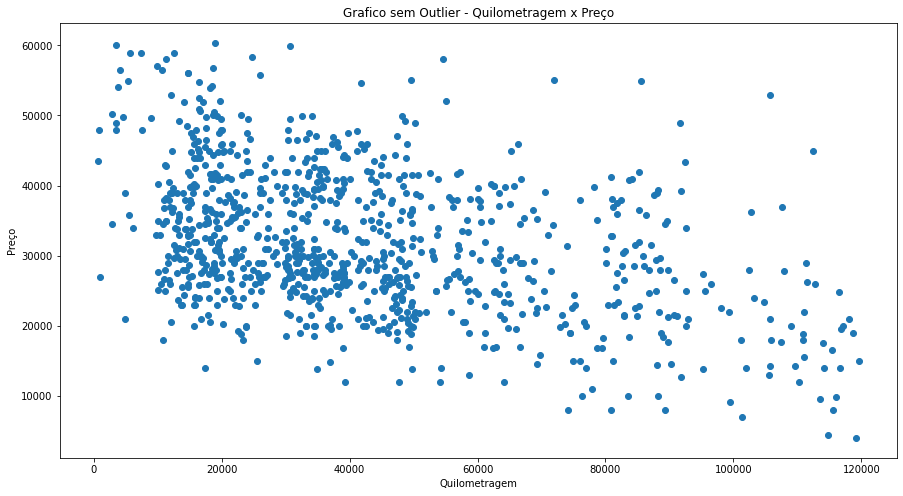

In [22]:
plt.figure(figsize=[15,8])
plt.title("Grafico sem Outlier - Quilometragem x Preço")
plt.xlabel('Quilometragem')
plt.ylabel("Preço")
plt.scatter(dff['Milage'], dff['Price'])
plt.show()

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
#Variavel Target  = Preço
#Feature = Quilometragem

X = dff.iloc[:,1].values.reshape(-1,1)
y = dff.iloc[:,0].values.reshape(-1,1)

x_train, x_test, y_train, y_teste = train_test_split(X, y, test_size=0.2, random_state=47)

In [25]:
#GRID SEARCH
from sklearn.model_selection import GridSearchCV
class gridSearchAll():
    
    def __init__(self, scoring, num_folds):
        self.grid_models = []
        self.scoring = scoring
        self.num_folds = num_folds
        self.best = []
    
    def insert_model(self, estimator_base, param_grid):
        self.grid_models.append([estimator_base, param_grid])
    def fit_all(self, X, y):
      for est, param in self.grid_models:
        grid = GridSearchCV(estimator = est, 
                    param_grid = param, 
                    scoring = self.scoring, 
                    cv = self.num_folds)
        grid.fit(X, y)
        self.best.append(grid)

    def best_all_grid_models(self):
      best_models = []
      for grid in self.best:
        best_models.append(grid.best_estimator_)
      print("Melhores Modelos:")
      print(best_models)

In [26]:
mygrid = gridSearchAll(scoring='r2',num_folds=10)

In [27]:
#Estimadores
knn = KNeighborsRegressor()
dtr =  DecisionTreeRegressor()
#Params
params_knn = {"n_neighbors":[1,2,3,4,5,6]}
params_dtr = {"max_depth":[1,2,5,6,7,8,9,10,20,25,30,35,40]}
params_svr = {"n_samples"}

In [28]:
mygrid.insert_model(knn, params_knn)
mygrid.insert_model(dtr, params_dtr)

In [29]:
mygrid.grid_models

[[KNeighborsRegressor(), {'n_neighbors': [1, 2, 3, 4, 5, 6]}],
 [DecisionTreeRegressor(),
  {'max_depth': [1, 2, 5, 6, 7, 8, 9, 10, 20, 25, 30, 35, 40]}]]

In [30]:
mygrid.fit_all(x_train, y_train)

In [31]:
mygrid.best_all_grid_models()

Melhores Modelos:
[KNeighborsRegressor(n_neighbors=6), DecisionTreeRegressor(max_depth=2)]


In [32]:
#Pegando os melhores Parametros
modelo_DTR = DecisionTreeRegressor(max_depth=2)
modelo_knn = KNeighborsRegressor(n_neighbors=6)
modelo_lr = LinearRegression()

In [33]:
modelo_DTR.fit(x_train, y_train)
modelo_knn.fit(x_train, y_train)
modelo_lr.fit(x_train, y_train)

LinearRegression()

In [34]:
ypred_DTR = modelo_DTR.predict(x_train)
ypred_knn = modelo_knn.predict(x_train)
ypred_lr = modelo_lr.predict(x_train)

In [35]:
#SCORE KNN
r2_score(y_true=y_train, y_pred = ypred_knn)

0.30478287869361664

In [36]:
#SCORE DecisionTreeRegressor
r2_score(y_true=y_train, y_pred = ypred_DTR)

0.1730435767309263

In [37]:
#SCORE LinearRegression
r2_score(y_true=y_train, y_pred = ypred_lr)

0.1606627761320948

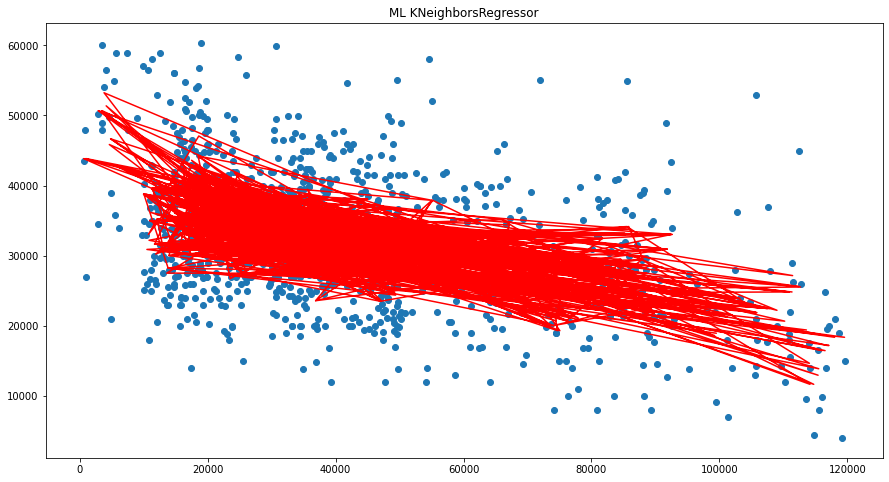

In [38]:
plt.figure(figsize=[15,8])
plt.title("ML KNeighborsRegressor")
plt.scatter(dff['Milage'], dff['Price'])
plt.plot(x_train, ypred_knn, color='red')
plt.show()

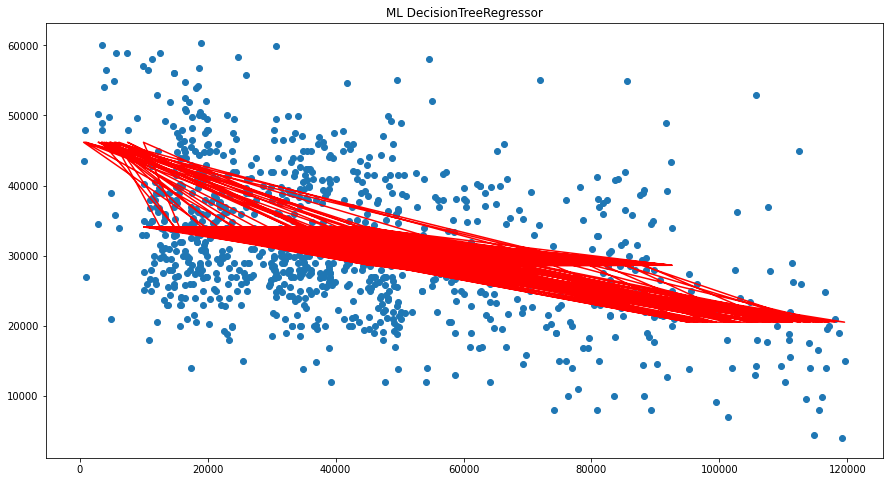

In [39]:
plt.figure(figsize=[15,8])
plt.title("ML DecisionTreeRegressor")
plt.scatter(dff['Milage'], dff['Price'])
plt.plot(x_train, ypred_DTR, color='red')
plt.show()

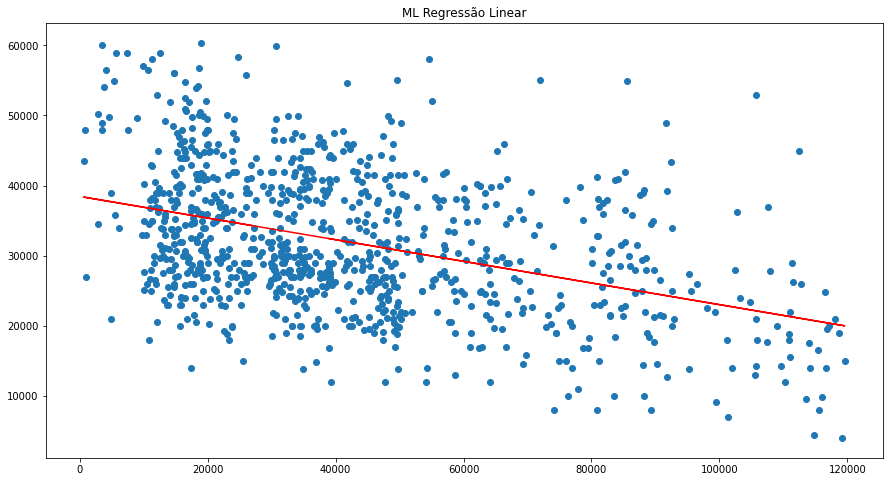

In [40]:
plt.figure(figsize=[15,8])
plt.title("ML Regressão Linear")
plt.scatter(dff['Milage'], dff['Price'])
plt.plot(x_train, ypred_lr, color='red')
plt.show()

In [41]:
#Para Uma veiculo com Quilometragem de 80000, utilizando Knn
modelo_knn.predict([[80000]])

array([[29210.33333333]])

In [ ]:
#Para Uma veiculo com Quilometragem de 80000, utilizando DecisionTree
modelo_DTR.predict([[80000]])

array([28638.20408163])

In [ ]:
#Para Uma veiculo com Quilometragem de 80000, utilizando Regressão Linear
modelo_lr.predict([[80000]])

array([[26110.34915606]])